# Modèles de scoring

Pour le moment j'ai juste fait une moyenne géométrique des deux scores de durée et de prix, qui sont assez similaires.  
Comme on a un pb avec les vraies valeurs des stations j'ai fait une simulation-test stochastique, mais de toute façon il faudra aussi mettre les prix à l'échelle, pour passer des prix du mètre carré à l'achat au prix au mètre carré à la location, je sais pas bien comment faire encore.

Les deux modèles de score prennent en entrée une valeur souhaitée par l'utilisateur (duration_moyen ou price_moyen), qui sert ensuite à attribuer un score à la station en fonction de son prix et de son éloignement (duration).  
J'ai choisi une simple gaussienne, mais on pourra affiner si besoin.  J'ai mis un plateau pour les valeurs extrêmes à gauche, parce que entre 0 et 15min pour aller au taf, ben ça fait pas une grosse diff, on va surtout départager par rapport au prix dans ces cas-là. On pourra affiner si besoin.



### Score Duration

On adopte le modèle suivant : 
$$ score_{duration}\big(duration, temps_{moyen}\big) = \begin{cases}1 &\text{si duration <= temps_moyen}\\
                                                        \mathcal{N}(\mu,\sigma²)&sinon
                                            \end{cases}$$
Avec : 
$$\mu = 0.2 \times temps_{moyen}$$
$$\sigma = 0.7 \times temps_{moyen}$$

<div class="alert alert-danger">
J'ai mis $\mu = 0.1$ et $\sigma = 0.4$ pour bien différencier le score même avec très peu de stations, car on peut pas encore filtrer leur nombre.

In [1]:
import numpy as np
from scipy.stats import norm
def score_duration(duration, temps_moyen=30):
    mu = temps_moyen*0.2
    sigma = temps_moyen*0.7
    if duration <= mu:
        score = 1
        return(score)
    else:
        score = norm.pdf(duration, mu, sigma)*np.sqrt(2*np.pi)*sigma
        return(score)

In [2]:
import matplotlib.pyplot as plt
points = [x for x in range(60)]
scores = [score_duration(x) for x in points]
plt.plot(points, scores)

### Score Price

On adopte le modèle suivant : 
$$ score_{price}\big(price, price_{moyen}\big) = \begin{cases}1 &\text{si price <= price_moyen}\\
                                                        \mathcal{N}(\mu,\sigma²)&sinon
                                            \end{cases}$$
Avec : 
$$\mu = 0.6 \times price_{moyen}$$
$$\sigma = 0.3 \times price_{moyen}$$

In [3]:
from scipy.stats import norm
def score_price(price, price_moyen=10*10**3):
    mu = price_moyen*0.6
    sigma = price_moyen*0.3
    if price <= mu:
        score = 1
        return(score)
    else:
        score = norm.pdf(price, mu, sigma)*np.sqrt(2*np.pi)*sigma
        return(score)

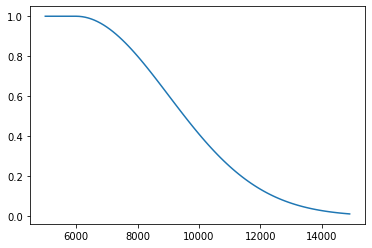

In [4]:
import matplotlib.pyplot as plt
points = [x*100 for x in range(50,150)]
scores = [score_price(x) for x in points]
plt.plot(points, scores)

### Score Station

SOIT :  
Moyenne RMSE :
$$ score_{station} = \sqrt{ score_{price}² + score_{duration}² }$$

SOIT :  
Moyenne Harmonique :
$$ score_{station} = \frac{score_{price} \times score_{duration}}{score_{price} + score_{duration}} = \frac{1}{\frac{1}{score_{price}} + \frac{1}{score_{duration}} }$$

In [5]:
def score_station(duration, price, temps_moyen=30, price_moyen=11*10**3, scoring='harmonic'):
    score_prix = score_price(price, price_moyen)
    score_duree = score_duration(duration, temps_moyen)
    if scoring == 'rmse':
        return(np.sqrt(score_prix**2 + score_duree**2)/1.4142)
    else :
        return(np.sqrt((score_prix*score_duree*2)/(score_prix+score_duree)))

### Score All

In [6]:
def score_all(liste_duration, liste_prix, temps_moyen=30, price_moyen=10*10**3, scoring='harmonic'):
    scores = []
    for prix, duree in zip(liste_prix, liste_duration):
        scores.append(score_station(duree, prix, temps_moyen, price_moyen, scoring))
    return(scores)

# Exemple, comparaison des deux modèles :

### Pour une durée de 30min

In [7]:
n = 10
durations = [30]*n
prices = np.linspace(5,15, n)*1000

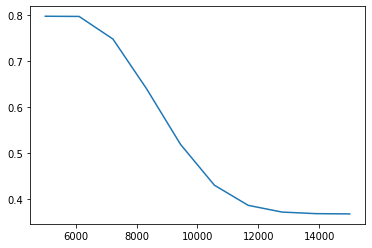

In [8]:
import matplotlib.pyplot as plt
scores = score_all(durations, prices, scoring='rmse')
plt.plot(prices, scores)

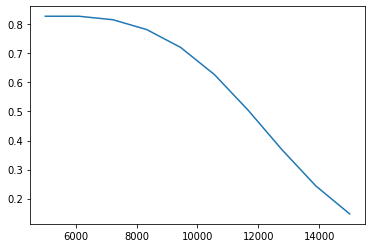

In [9]:
import matplotlib.pyplot as plt
scores = score_all(durations, prices, scoring='harmonic')
plt.plot(prices, scores)

### Pour une durée de 10 min :

In [10]:
n = 10
durations = [10]*n
prices = np.linspace(5,15, n)*1000

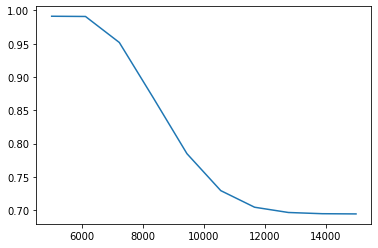

In [11]:
import matplotlib.pyplot as plt
scores = score_all(durations, prices, scoring='rmse')
plt.plot(prices, scores)

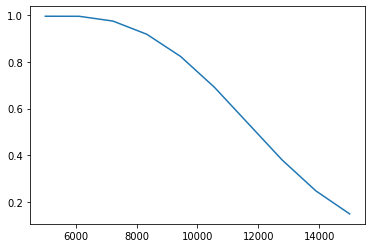

In [12]:
import matplotlib.pyplot as plt
scores = score_all(durations, prices, scoring='harmonic')
plt.plot(prices, scores)

### Pour une durée de 60 min

In [13]:
n = 10
durations = [60]*n
prices = np.linspace(5,15, n)*1000

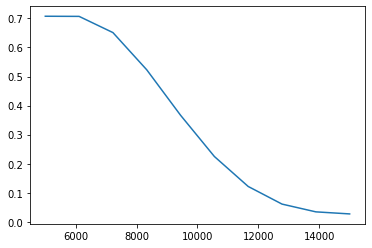

In [14]:
import matplotlib.pyplot as plt
scores = score_all(durations, prices, scoring='rmse')
plt.plot(prices, scores)

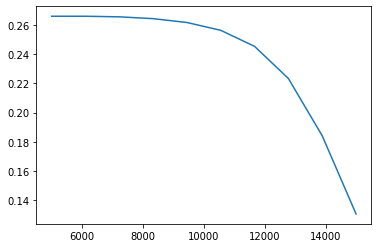

In [15]:
#Bien voir que le max est à 0.07, soit quasi zéro...
import matplotlib.pyplot as plt
scores = score_all(durations, prices, scoring='harmonic')
plt.plot(prices, scores)

<div class="alert alert-info">

**Pour les cas extrêmes, la moyenne harmonique est bien mieux**, car elle évite un certain effet "plancher".
Au delà d'un seuil (zéro), une des caractéristiques n'a plus de poids en RMSE:  
Si une station est très éloignée, son score de temps sera de 0, mais son score total peut quand même être assez bon si le prix a un score de 1. Donc on peut de retrouver avec des moyennes à $\sqrt{ 1^2 + 0^2} = 1$ alors que la station ests hyper hyper loin.  Cela ne reflète pas sa véritable attractivité...  

A l'inverse, un score de 0 en temps donnera un score de 0 pour la moyenne harmonique, ce qui est bien plus fidèle.